In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.feature_selection import chi2


from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_ind, chi2_contingency



# Reading Files

In [128]:
df = pd.read_csv('../../data/processedData/training_data.csv')
df = df.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)
df

,Cardiovascular,LOS,ICU_ADMIN_FLAG,HEIGHT,WEIGHT,SEX,ASA_RATING_C,Abnormal Flag,ORDER_STATUS_IMPACT,discharge_risk_level,...,ecg_std_magnitude,Calcium,Erythrocyte distribution width,Erythrocyte mean corpuscular hemoglobin,Erythrocyte mean corpuscular hemoglobin concentration,Erythrocyte mean corpuscular volume,Erythrocytes,Hematocrit,Hemoglobin,cardiac_history
0,0.0,1.0,0,187.960000,92.6991,1,2.0,0.355511,1.0,1,...,25.027281,0,0,0,0,0,0,0,0,1.0
1,0.0,10.0,1,168.251459,100.9530,1,3.0,0.355511,1.0,1,...,72.740000,0,0,0,0,0,0,0,0,1.0
2,0.0,10.0,1,168.251459,100.9530,1,3.0,0.355511,1.0,1,...,4.130000,0,0,0,0,0,0,0,0,1.0
3,0.0,3.0,1,160.020000,70.1064,0,2.0,0.355511,1.0,1,...,8.180000,0,0,0,0,0,0,0,0,1.0
4,0.0,3.0,1,168.251459,86.3922,1,2.0,0.000000,2.0,3,...,25.027281,2,1,1,1,1,2,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,1.0,34.0,1,165.100000,72.1698,1,3.0,0.000000,0.0,1,...,14.240000,2,3,3,3,3,3,2,2,1.0
1600,0.0,1.0,0,154.940000,70.1592,0,3.0,2.000000,1.0,1,...,25.027281,0,0,0,0,0,0,0,0,1.0
1601,1.0,77.0,1,166.370000,52.2756,0,3.0,0.000000,0.0,1,...,25.027281,2,3,1,2,1,3,2,2,0.0
1602,0.0,7.0,1,162.560000,71.4291,0,3.0,0.000000,0.0,1,...,25.027281,2,3,3,3,3,2,2,2,0.0


# Model Fitting

### Logistic Regression Model with All Features: Performance Evaluation and ROC Curve

In [129]:
# Split the dataset into training and testing sets
X = df.drop('Cardiovascular', axis=1)  # Features (drop the target variable 'Cardiovascular')
y = df['Cardiovascular']  # Target variable

# Split data into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [130]:
# Create a Pipeline that includes Logistic Regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C for logistic regression
}

# Perform 20-fold cross-validation for hyperparameter search
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Conduct hyperparameter search on the training set
grid_search.fit(X_train, y_train)

# Output the best parameter combination
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'log_reg__C': 0.01}


In [131]:
# Evaluate the performance of the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print performance metrics
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")
print(f"Test set F1 Score: {f1:.3f}")


Test set Accuracy: 0.869
Test set Precision: 0.737
Test set Recall: 0.731
Test set F1 Score: 0.734


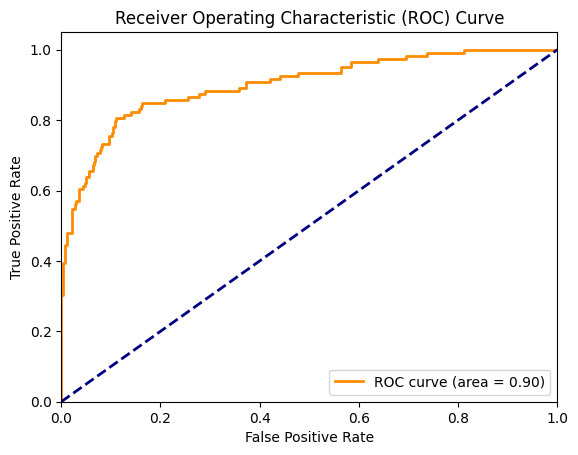

In [132]:
# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate (fpr), true positive rate (tpr), and thresholds
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot a diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()  # Display the plot

The accuracy and precision are relatively high, indicating that the model performs well in predicting positive cases. However, the recall is relatively low, which suggests that the model is not effective in identifying positive cases (i.e., patients with cardiovascular diseases), potentially missing a significant number of positive samples.

### Logistic Regression Model with Selected Features (p-value < 0.1): Performance Evaluation and ROC Curve

In [145]:
# Store p-values for numerical and categorical features separately
p_values = {}

# Perform t-test for numerical features
for column in X.select_dtypes(include=[np.number]).columns:
    class_0 = X[y == 0][column]  # Values for class 0
    class_1 = X[y == 1][column]  # Values for class 1
    t_stat, p_value = ttest_ind(class_0, class_1, nan_policy='omit')  # Perform t-test
    p_values[column] = p_value  # Store p-value

# Perform chi-square test for categorical features
for column in X.select_dtypes(exclude=[np.number]).columns:
    contingency_table = pd.crosstab(X[column], y)  # Create a contingency table
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)  # Perform chi-square test
    p_values[column] = p_value  # Store p-value

# Convert p-values results to a DataFrame and sort by p-value in ascending order
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'P-value'])
p_values_df = p_values_df.sort_values(by='P-value', ascending=False)

# Display the result
print("\nFeature Significance (P-values):")
print(p_values_df.to_string(index=False))



Feature Significance (P-values):
                                              Feature       P-value
                                        qrs_peak_freq  4.074451e-01
                                               HEIGHT  3.983592e-01
                                        vt_freq_power  2.384645e-01
                                       qrs_freq_power  1.661079e-01
                                    ecg_std_magnitude  1.146625e-01
                                        arc_bandwidth  1.000575e-01
                                                  SEX  5.341864e-02
                                        vf_freq_power  5.269774e-02
                                           BIRTH_DATE  4.187480e-02
                                        Abnormal Flag  1.896839e-02
                                               WEIGHT  1.529719e-02
                                   arc_peak_frequency  1.194707e-04
                                  arc_spectral_energy  1.244666e-06
              

Based on the output results, it is evident that some variables have low statistical significance. Therefore, I plan to remove these insignificant variables to simplify the model and improve its performance.

In [146]:
X_with_constant = sm.add_constant(X)  # Add a constant term to the model
logit_model = sm.Logit(y, X_with_constant)  # Create a logistic regression model
result = logit_model.fit()  # Fit the logistic regression model

# Get p-values
p_values = result.pvalues  # Extract the p-values from the model

# Select variables with p-values < 0.1
significant_vars = p_values[p_values < 0.1].index.tolist()  # Select variables with p-values < 0.1
significant_vars.remove('const')  # Remove the constant term

# Train the model based on the selected significant variables
X_significant = X[significant_vars]  # Create a new dataset with the significant variables
print(X_significant)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)  # 30% test set


Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
       LOS  ASA_RATING_C  ORDER_STATUS_IMPACT  arc_peak_frequency  \
0      1.0           2.0                  1.0            4.843582   
1     10.0           3.0                  1.0            2.060000   
2     10.0           3.0                  1.0            9.040000   
3      3.0           2.0                  1.0            1.600000   
4      3.0           2.0                  2.0            4.843582   
...    ...           ...                  ...                 ...   
1599  34.0           3.0                  0.0            0.560000   
1600   1.0           3.0                  1.0            4.843582   
1601  77.0           3.0                  0.0            4.843582   
1602   7.0           3.0                  0.0            4.843582   
1603   7.0           3.0                  0.0            4.843582   

      Erythrocyte distribution width  Erythrocyte mean corpuscular he

In [147]:
# Create a pipeline that includes logistic regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

# Perform hyperparameter search using 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Fit the grid search on the training set
grid_search.fit(X_train, y_train)

# Output the best combination of hyperparameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'log_reg__C': 0.1}


Test set Accuracy: 0.880
Test set Precision: 0.821
Test set Recall: 0.655
Test set F1 Score: 0.729


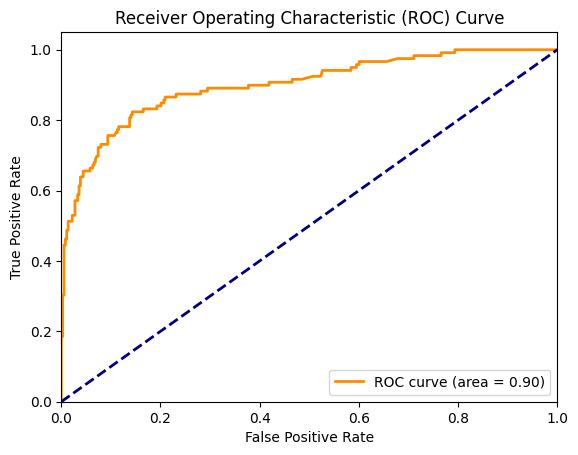

In [148]:
# Evaluate the performance of the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print performance metrics
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")
print(f"Test set F1 Score: {f1:.3f}")


# Calculate ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Logistic Regression with Selected Features (p-value < 0.05): Model Performance and ROC Curve

In [142]:
# Add a constant term to the feature set
X_with_constant = sm.add_constant(X)

# Fit a logistic regression model using the selected features
logit_model = sm.Logit(y, X_with_constant)
result = logit_model.fit()

# Get p-values for each feature
p_values = result.pvalues

# Filter variables with p-values < 0.05
significant_vars = p_values[p_values < 0.05].index.tolist()
significant_vars.remove('const')  # Remove the constant term

# Train the model using only the significant variables
X_significant = X[significant_vars]
print(X_significant)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)

Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
       LOS  ASA_RATING_C  ORDER_STATUS_IMPACT  Erythrocyte distribution width  \
0      1.0           2.0                  1.0                               0   
1     10.0           3.0                  1.0                               0   
2     10.0           3.0                  1.0                               0   
3      3.0           2.0                  1.0                               0   
4      3.0           2.0                  2.0                               1   
...    ...           ...                  ...                             ...   
1599  34.0           3.0                  0.0                               3   
1600   1.0           3.0                  1.0                               0   
1601  77.0           3.0                  0.0                               3   
1602   7.0           3.0                  0.0                               3   
1603   

In [143]:
# Create a pipeline that includes logistic regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

# Perform hyperparameter search using 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Fit the grid search on the training set
grid_search.fit(X_train, y_train)

# Output the best combination of hyperparameters
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'log_reg__C': 0.01}


Test set Accuracy: 0.873
Test set Precision: 0.750
Test set Recall: 0.731
Test set F1 Score: 0.740


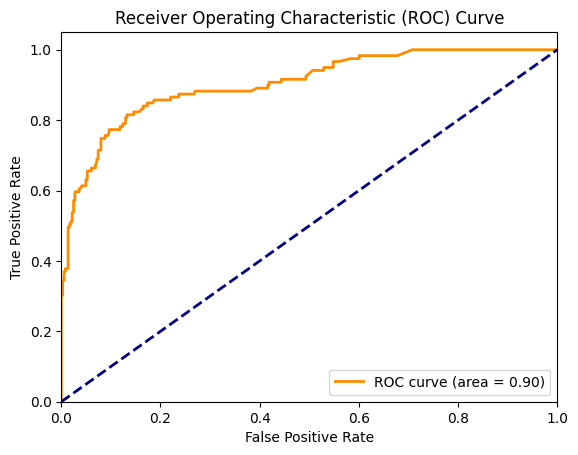

In [144]:
# Evaluate the performance of the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print performance metrics
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")
print(f"Test set F1 Score: {f1:.3f}")

# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the diagonal line (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title for the plot
plt.legend(loc="lower right")  # Display the legend
plt.show()  # Show the plot

Compared with the model without feature selection, the current model does not show significant differences, particularly in terms of recall, which is our main focus. As a next step, we will explore other methods to improve the model's performance

#### Handling Imbalanced Data with Balanced Class Weights in Logistic Regression

In [35]:
print(y.value_counts())

Cardiovascular
0.0    1206
1.0     398
Name: count, dtype: int64


From the output it can be seen that the y data is unbalanced. There are 1206 samples with a category of 0.0, while there are only 398 samples with a category of 1.0. Typically, when there is a large difference in the number of samples between categories, the model may be biased towards predicting the category with the larger number during training.

Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
Best Parameters:  {'log_reg__C': 0.1}
Test set Accuracy: 0.824
Test set Precision: 0.604
Test set Recall: 0.832
Test set F1 Score: 0.700


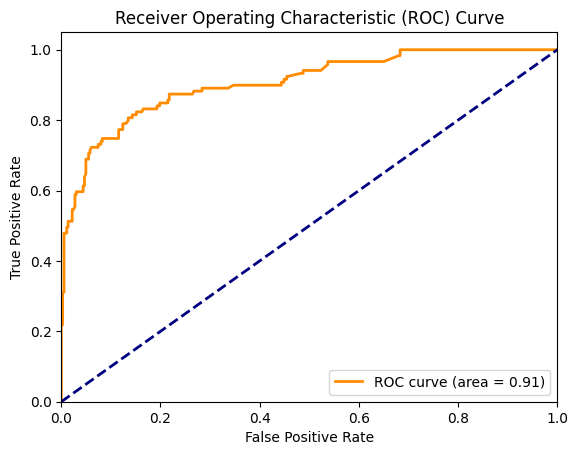

In [153]:

X = df.drop('Cardiovascular', axis=1)
y = df['Cardiovascular']
X_with_constant = sm.add_constant(X)  # Add a constant term to the model
logit_model = sm.Logit(y, X_with_constant)  # Create logistic regression model
result = logit_model.fit()  # Fit the model

# Get p-values from the model
p_values = result.pvalues

# Select variables with p-values < 0.05
significant_vars = p_values[p_values < 0.05].index.tolist()
significant_vars.remove('const')  # Remove the constant term

# Train the model based on the selected significant variables
X_significant = X[significant_vars]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)

# Create a pipeline with Logistic Regression and perform 20-fold cross-validation with hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('log_reg', LogisticRegression(solver='liblinear', class_weight='balanced'))  # Use Logistic Regression model with balanced class weights
])

# Define the hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization strength (C parameter)
}

# Use 20-fold cross-validation for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Perform hyperparameter tuning on the training set
grid_search.fit(X_train, y_train)

# Evaluate the performance of the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Output the best combination of hyperparameters
print("Best Parameters: ", grid_search.best_params_)
# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print performance metrics
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")
print(f"Test set F1 Score: {f1:.3f}")

# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the diagonal line (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title for the plot
plt.legend(loc="lower right")  # Display the legend
plt.show()  # Show the plot

This model prioritizes recall, achieving a higher recall score (0.832) compared to the original model. By using class_weight='balanced', it is better suited for medical data where minimizing false negatives is critical, ensuring more accurate identification of positive cases

#### Handling Imbalanced Data Using SMOTE in Logistic Regression

Optimization terminated successfully.
         Current function value: 0.329072
         Iterations 8
Best Parameters:  {'log_reg__C': 10}
Test set Accuracy: 0.830
Test set Precision: 0.619
Test set Recall: 0.807
Test set F1 Score: 0.701


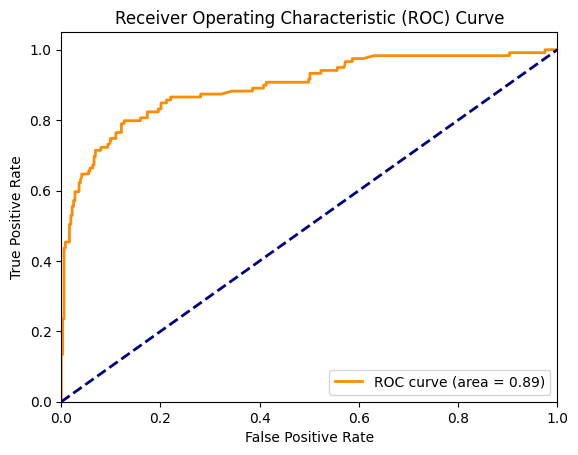

In [154]:
X = df.drop('Cardiovascular', axis=1)  # Split features from the target variable
y = df['Cardiovascular']  # Target variable

# Step 1: Select significant variables based on p-values
X_with_constant = sm.add_constant(X)  # Add constant term for intercept
logit_model = sm.Logit(y, X_with_constant)  # Logistic regression model
result = logit_model.fit()  # Fit the model

# Get p-values
p_values = result.pvalues

# Select variables where p_values < 0.1
significant_vars = p_values[p_values < 0.1].index.tolist()
significant_vars.remove('const')  # Remove the constant term

# Train the model using only significant variables
X_significant = X[significant_vars]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Create a pipeline with logistic regression and perform 20-fold cross-validation and hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardization step
    ('log_reg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Define hyperparameter search space
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

# Perform hyperparameter search with 20-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='f1', n_jobs=-1)

# Fit the grid search on the SMOTE-processed training set
grid_search.fit(X_train_smote, y_train_smote)

# Evaluate the performance of the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Output the best combination of hyperparameters
print("Best Parameters: ", grid_search.best_params_)

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print performance metrics
print(f"Test set Accuracy: {accuracy:.3f}")
print(f"Test set Precision: {precision:.3f}")
print(f"Test set Recall: {recall:.3f}")
print(f"Test set F1 Score: {f1:.3f}")

# Calculate the ROC curve
y_score = best_model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Compute false positive rate and true positive rate
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve (AUC)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Plot the diagonal line (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Title for the plot
plt.legend(loc="lower right")  # Display the legend
plt.show()  # Show the plot


Using SMOTE improved recall but slightly decreased precision and accuracy, making the model better at identifying the minority class. Comparing SMOTE with class_weight='balanced', SMOTE achieved higher precision but lower recall, while the balanced class weight method increased recall at the expense of precision. Both methods effectively improved the model's ability to handle imbalanced data, but since we focus more on predicting postoperative cardiovascular risk and prioritize recall, the model with `class_weight='balanced'` is selected as the final model.